Testing the VQE process on the local machine
=================================================

In [70]:
from functools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

from defining_the_hamiltonian import fermi_hubbard_hamiltonian, swap_electron, number_up_down

from qiskit.circuit.library import EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import Estimator as Estimator
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer import AerSimulator


from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.sampler import SamplerV2 as Sampler
from qiskit import transpile

from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit.library import n_local
from qiskit.quantum_info.operators import Pauli
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import excitation_preserving
# from qiskit.primitives import Sampler

from qiskit_nature.second_q.circuit.library import UCC
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.mappers import InterleavedQubitMapper
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.hamiltonians.lattices import Lattice
from qiskit_algorithms.minimum_eigensolvers import VQE
import qiskit_algorithms.optimizers as opt
from qiskit.quantum_info import Statevector

from qiskit.circuit import Parameter

In [44]:
backend = AerSimulator()
# sherbrooke = FakeSherbrorooke()
# backend = AerSimulator.fm_backend(sherbrooke)


In [45]:
verticies = 6
edges = [(0,1),(0,2),(0,3),(0,4), 
         (5,1),(5,2),(5,3),(5,4), 
         (2,1),(3,2),(4,3),(1,4), ]

def X_i(verticies:int, i:int) -> str:
    return "I"*i + "X" + "I"*(verticies-i-1)

edge_op = SparsePauliOp.from_list([(X_i(verticies, i)+X_i(verticies, j), 1)
                for (v1, v2) in edges for i,j in [(v1,v2), (v2, v1)]])
opposite_op = SparsePauliOp.from_list([("I"*v + "X" + "I"*(verticies-1) + "X" + "I"*(verticies-v-1), 1)
                for v in range(0, verticies)])
same_site_op = SparsePauliOp.from_list([(X_i(verticies, v)+X_i(verticies, v), 1)
                for v in range(0, verticies)])

In [46]:
nodes = verticies

weighted_edges = [(i,j,1) for i,j in edges]

octahedron = Lattice.from_nodes_and_edges(num_nodes=nodes, weighted_edges=weighted_edges)
lattice = octahedron.uniform_parameters(
    uniform_interaction=-1,uniform_onsite_potential=0)
fermi_hubb = FermiHubbardModel(lattice, onsite_interaction=1)

There are 18 parameters.


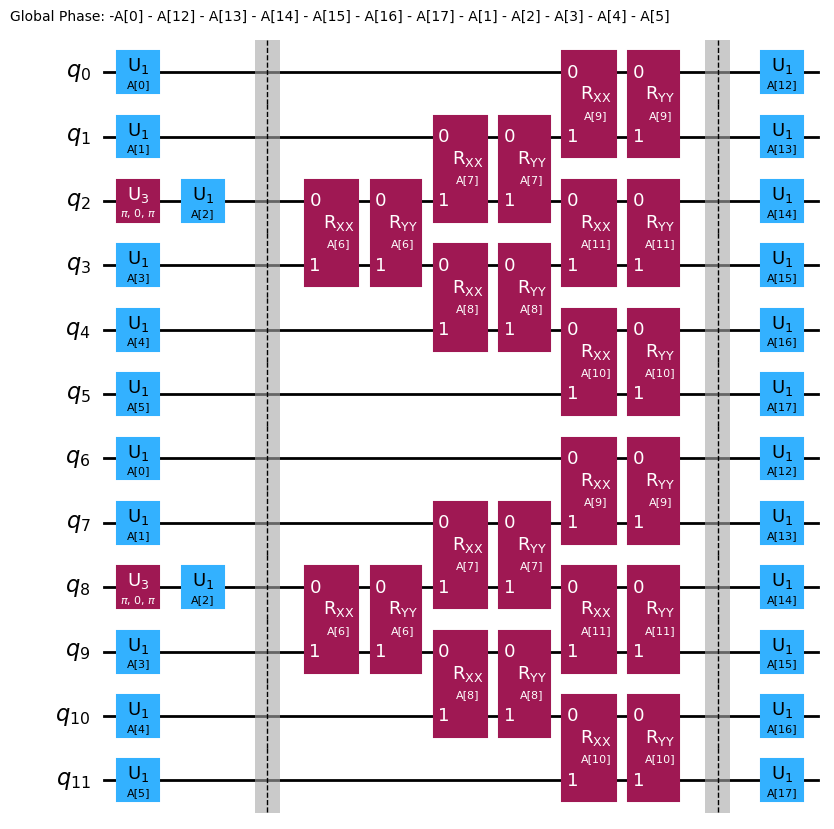

In [47]:

# hamiltonian = JordanWignerMapper().map(fermi_hubb.second_q_op())
hamiltonian = fermi_hubbard_hamiltonian()

theta=Parameter("theta")

qc = QuantumCircuit(verticies*2)
qc.x(2)
qc.x(verticies+2)
# qc.rxx(theta, 2,3)


# ansatz = evolved_operator_ansatz([edge_op, same_site_op], reps=1, insert_barriers=True)
# ansatz = (n_local(verticies*2, "rz", "cx", "full", reps=2, insert_barriers=True))
# entanglement = [(i+verticies*spin, j+verticies*spin) 
#                 for i,j in edges for spin in [0,1]] + [(i, i+verticies) for i in range(verticies)]
# ansatz = n_local(verticies*2, "rx", "cx", "linear" , reps=10)
six_qubit_ansatz = excitation_preserving(verticies, reps=1, 
                                          insert_barriers=True,
                                          skip_final_rotation_layer=False,
                                          entanglement = [(2,3),(1,2),(3,4),(0,1),(4,5),(2,3)],
                                          mode = "iswap",
                                          parameter_prefix="A")

# qc.compose(six_qubit_ansatz,
#            qubits=(range(0, verticies)),
#            inplace=True)
# for i in range(0, verticies):
#     qc.cx(i,i+6)
qc.compose(six_qubit_ansatz,
           qubits=range(0,verticies),
           inplace=True)
qc.compose(six_qubit_ansatz,
           qubits=(range(verticies, 2*verticies)),
           inplace=True)
ansatz = qc
# ansatz = EfficientSU2(hamiltonian.num_qubits)
# ansatz = RealAmplitudes(hamiltonian.num_qubits)

# ansatz = UCC(num_spatial_orbitals=6, 
#              num_particles=(1,1),
#              qubit_mapper=JordanWignerMapper(),
#              excitations=2)

ansatz.draw("mpl")

num_of_parameters = ansatz.num_parameters

print(f"There are {num_of_parameters} parameters.")
ansatz.decompose().draw("mpl", style="iqp")

In [ ]:
target = backend.target
pm:PassManager = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [49]:
# eig_vec = np.linalg.eigh(hamiltonian.to_matrix())
# print(eig_vec[0][0])
# [(f"{s:012b}", c) for s,c in enumerate(eig_vec[1][:,0]) if (abs(c)) > 1e-10]

In [50]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [ ]:
x0 = 2 * np.pi * np.random.random(num_of_parameters)
len(x0)

18

In [ ]:
print(ansatz_isa.count_ops())

OrderedDict({'rz': 24, 'rxx': 12, 'ryy': 12, 'barrier': 4, 'x': 2})


In [53]:
# x0= x_tested

# token="4c490f1c7d2312d4615a8061d67227acf084aef01e4a709efffeae7692faa04b6b0e3357612c887185e8e63e9aa47b28a268b1c2f65a4921f4aaa10e8d58ee3f"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
# service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
# # # Choose backend
# backend = service.backend("ibm_sherbrooke")  # or "ibm_brisbane", "ibm_oslo", etc.
# target = backend.target
# pm:PassManager = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

estimator = Estimator(backend)
estimator.options.default_shots = 10000
res = sci.optimize.minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",)

print("done")

Iters. done: 1 [Current cost: 0.33520000000000005]
Iters. done: 2 [Current cost: 0.31099999999999994]
Iters. done: 3 [Current cost: 0.3405000000000004]
Iters. done: 4 [Current cost: 0.2981000000000001]
Iters. done: 5 [Current cost: 0.3383999999999999]
Iters. done: 6 [Current cost: 0.3517]
Iters. done: 7 [Current cost: 0.27269999999999983]
Iters. done: 8 [Current cost: -1.4323000000000001]
Iters. done: 9 [Current cost: -1.2346]
Iters. done: 10 [Current cost: 1.0271000000000003]
Iters. done: 11 [Current cost: -1.4813]
Iters. done: 12 [Current cost: 0.9490999999999993]
Iters. done: 13 [Current cost: -2.378100000000001]
Iters. done: 14 [Current cost: -2.0657000000000005]
Iters. done: 15 [Current cost: -2.3432999999999993]
Iters. done: 16 [Current cost: -2.8534000000000015]
Iters. done: 17 [Current cost: -1.0213999999999999]
Iters. done: 18 [Current cost: -4.0703]
Iters. done: 19 [Current cost: -2.8538]
Iters. done: 20 [Current cost: -4.433199999999999]
Iters. done: 21 [Current cost: -4.408

In [54]:
[(f"{s:012b}", c) 
 for s,c in enumerate(Statevector(ansatz.assign_parameters(cost_history_dict["prev_vector"])).data)
 if abs(c) > 1e-10]

[('000001000001', np.complex128(0.07658920078256312-0.17233619015142598j)),
 ('000001000010', np.complex128(0.07067206891583394-0.16462967446256455j)),
 ('000001000100', np.complex128(0.07296183068724735-0.1627035311734038j)),
 ('000001001000', np.complex128(0.09133859377863567-0.14482468410523325j)),
 ('000001010000', np.complex128(0.09023801108613154-0.1568379637994989j)),
 ('000001100000', np.complex128(0.0838961762088344-0.14153823750381747j)),
 ('000010000001', np.complex128(0.07067206891583389-0.1646296744625647j)),
 ('000010000010', np.complex128(0.06514436136192961-0.15723768140166283j)),
 ('000010000100', np.complex128(0.06734270143361182-0.15543566039283313j)),
 ('000010001000', np.complex128(0.08501497724169324-0.13867419457677127j)),
 ('000010010000', np.complex128(0.08382444159957124-0.1500725004469872j)),
 ('000010100000', np.complex128(0.07798499975657075-0.13546247251563676j)),
 ('000100000001', np.complex128(0.07296183068724735-0.1627035311734038j)),
 ('000100000010', 

In [68]:
# sherbrooke = FakeSherbrooke()
# backend_noise = AerSimulator.from_backend(sherbrooke)

# target_noise = backend_noise.target
# pm:PassManager = generate_preset_pass_manager(target=target_noise, optimization_level=3)

# ansatz_isa = pm.run(ansatz)
# hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)


x_tested = cost_history_dict["prev_vector"]
res = Estimator(backend, options={"default_shots":25000}).run([(ansatz_isa, [hamiltonian_isa], x_tested)]).result()
res[0].data.evs[0]

np.float64(-7.77756889724411)

In [74]:
x_tested = [2.94643803, 2.92618614, 6.26233282, 1.42829223, 2.24560625,
       3.64625209, 5.35537318, 4.66771912, 0.78057604, 2.33055485,
       2.40365874, 7.13592225, 3.57165629, 5.12974032, 3.57500561,
       2.14533438, 6.81715065, 5.25931923]
cost_history_dict["prev_vector"]

array([2.94643803, 2.92618614, 6.26233282, 1.42829223, 2.24560625,
       3.64625209, 5.35537318, 4.66771912, 0.78057604, 2.33055485,
       2.40365874, 7.13592225, 3.57165629, 5.12974032, 3.57500561,
       2.14533438, 6.81715065, 5.25931923])

In [108]:
token="4c490f1c7d2312d4615a8061d67227acf084aef01e4a709efffeae7692faa04b6b0e3357612c887185e8e63e9aa47b28a268b1c2f65a4921f4aaa10e8d58ee3f"
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
# # Choose backend
backend = service.backend("ibm_sherbrooke")  # or "ibm_brisbane", "ibm_oslo", etc.

target = backend.target
pm:PassManager = generate_preset_pass_manager(target=target, optimization_level=3)

# ansatz.measure_all()
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

sampler = Sampler(backend, options={"default_shots":15000})
job = sampler.run([(ansatz_isa, x_tested)])
result = job.result()
pub_result = result[0]
counts = pub_result.data.meas.get_counts()
counts: dict

In [112]:
sorted([(k, counts[k]) for k in counts.keys() if 2!=len(list(filter(lambda x: x=='1', k)))], key=lambda z: z[1], reverse=True)

[('010100010000', 71),
 ('011000000001', 69),
 ('010100000010', 66),
 ('011000010000', 61),
 ('010100000100', 59),
 ('010100000001', 57),
 ('011000000010', 55),
 ('011000000100', 53),
 ('010001010000', 50),
 ('000000000100', 49),
 ('011000001000', 48),
 ('000000010000', 48),
 ('010001000100', 46),
 ('000000100000', 46),
 ('010001000010', 45),
 ('010100100000', 45),
 ('010001100000', 45),
 ('000000000001', 44),
 ('010100001000', 43),
 ('000001000000', 42),
 ('011000100000', 42),
 ('010001000001', 41),
 ('000000000010', 40),
 ('010000000000', 40),
 ('010010010000', 39),
 ('000010000000', 39),
 ('010010000001', 39),
 ('010010000100', 37),
 ('010010100000', 36),
 ('000100000000', 36),
 ('001000000000', 35),
 ('010010000010', 32),
 ('110100010000', 31),
 ('010010001000', 31),
 ('000000001000', 30),
 ('010001001000', 26),
 ('000010000101', 24),
 ('000100010010', 24),
 ('111000010000', 23),
 ('100000000000', 22),
 ('110010010000', 22),
 ('000100110000', 22),
 ('000001011000', 22),
 ('01000001

In [113]:
sorted([(k, counts[k]) for k in counts.keys() if 2==len(list(filter(lambda x: x=='1', k)))], key=lambda z: z[1], reverse=True)

[('000001010000', 396),
 ('000010010000', 387),
 ('010000010000', 378),
 ('000100010000', 366),
 ('000001000100', 364),
 ('000100000001', 363),
 ('000100000100', 352),
 ('000010000100', 351),
 ('000010000001', 339),
 ('000100000010', 337),
 ('000001000010', 328),
 ('000010000010', 328),
 ('000001000001', 325),
 ('010000000001', 322),
 ('000001100000', 319),
 ('000100100000', 310),
 ('010000000100', 298),
 ('000010100000', 297),
 ('010000000010', 290),
 ('001000010000', 284),
 ('010000100000', 277),
 ('100000010000', 274),
 ('000010001000', 268),
 ('100000000100', 255),
 ('100000000001', 254),
 ('001000000001', 245),
 ('001000000010', 243),
 ('000001001000', 239),
 ('000100001000', 237),
 ('001000100000', 237),
 ('001000000100', 233),
 ('010000001000', 228),
 ('100000100000', 217),
 ('100000000010', 209),
 ('001000001000', 173),
 ('100000001000', 166),
 ('010100000000', 11),
 ('011000000000', 10),
 ('010001000000', 8),
 ('000000001010', 6),
 ('010010000000', 4),
 ('000000001100', 4),
 (